# Particle swarm optimization of a bullseye cavity for quantum emitter light extraction

**Note: the cost of running the entire notebook is higher than 10 FlexCredits.**

A bullseye cavity is characterized by concentric rings of alternating dielectrics, resembling a bullseye target. It has been successfully employed to enhance the collection efficiency and decay rate of various quantum emitters, including quantum dots, defect centers in diamond, and 2D materials.

In this notebook, we show how to set up a bullseye cavity simulation using Tidy3D and use Particle Swarm Optimization (PSO) to enhance the coupling efficiency from quantum emitters into the fundamental mode of an optical fiber. We will use the Tidy3D `Design` plugin to manage the PSO (which uses the free available python library [PySwarms](https://pyswarms.readthedocs.io/en/latest/index.html)) to easily create, compute and analyse the optimized bullseye cavity. For details about PSO you can see the notebook [Particle swarm optimization of a polarization beam splitter](../notebooks/ParticleSwarmOptimizedPBS.html). In addition, we show how to calculate the cavity Purcell factor, which is another important figure-of-merit within the context of cavity electrodynamics.

Let's start by importing the python libraries used throughout this notebook.

In [1]:
# Uncomment the following line to install pyswarms if it's not installed in your environment already
# pip install pyswarms

# Standard python imports
import numpy as np
import matplotlib.pylab as plt

# Import regular tidy3d
import tidy3d as td
import tidy3d.web as web
import tidy3d.plugins.design as tdd
from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run as run_mode_solver

## Cavity Geometry and Simulation Parameters

The cavity structure is inspired by `Hekmati, R., Hadden, J.P., Mathew, A. et al. Bullseye dielectric cavities for photon collection from a surface-mounted quantum-light-emitter. Sci Rep 13, 5316 (2023)` [DOI: 10.1038/s41598-023-32359-0](https://doi.org/10.1038/s41598-023-32359-0), where the authors presented a $TiO_{2}$ over $SiO_{2}$ bullseye cavity. In that work, the cavity was designed to enhance the emission from point sources, such as $WSe_{2}$ flakes, single dye molecules, and nano-diamonds, positioned just above the center of the structure. It was optimized using an iterative approach to enhance the power coupling into the numerical aperture (NA) of free-space optics and a low NA fiber.

Differently from that work, here we will set up the optimization to enhance the modal coupling efficiency of the generated photons into the collection fiber. When building an optimization scheme for practical applications, more advanced optimization strategies can be implemented to include other quantities of interest—for instance, the Purcell factor, which is important within the context of devices such as single-photon sources. The following figure shows the main cavity geometric parameters.

<img src="img/bullseye_psa_diagram.png" alt="Bullseye Cavity Diagram"  width="800"/>

In [2]:
# Initial parameters of the Bullseye cavity.
t_tio2 = 0.200  # TiO2 thin film thickness (um).
t_sio2 = 0.435  # SiO2 thin film thickness (um).
r_cav = 0.835  # Radius of the internal cavity (um).
p_bragg = 0.420  # Period of the Bragg reflector (um).
w_bragg = 0.155  # Gap width (etched region) of the Bragg reflector (um).
n_bragg = 8  # Number of Bragg periods.
n_tio2 = 2.50  # TiO2 refractive index (0.75 um).
n_sio2 = 1.45  # SiO2 refractive index (0.75 um).

# Collection fiber parameters (630HP).
r_core = 1.75  # Fiber core radius.
n_core = 1.46  # Core refractive index.
n_clad = 1.45  # Cladding refractive index.
d_cf = 2.0  # Distance between the cavity and the fiber.

# PSO optimization parameters.
iterations = 15  # Number of iterations.
n_particle = 5  # Number of particles in optimization.

# Simulation wavelength.
wl = 0.75  # Central simulation wavelength (um).
bw = 0.06  # Simulation bandwidth (um).
n_wl = 61  # Number of wavelength points within the bandwidth.

From the parameters defined before, a lot of variables are computed and used to set up the optimization.

In [3]:
# Wavelengths and frequencies.
wl_max = wl + bw / 2
wl_min = wl - bw / 2
wl_range = np.linspace(wl_min, wl_max, n_wl)
freq = td.C_0 / wl
freqs = td.C_0 / wl_range
freqw = 0.5 * (freqs[0] - freqs[-1])
run_time = 5e-12  # Simulation run time.

# Material definition.
mat_tio2 = td.Medium(permittivity=n_tio2 ** 2)  # TiO2 medium.
mat_sio2 = td.Medium(permittivity=n_sio2 ** 2)  # SiO2 medium.
mat_etch = td.Medium(permittivity=1)  # Etch medium.
mat_core = td.Medium(permittivity=n_core ** 2)  # Fiber core medium.
mat_clad = td.Medium(permittivity=n_clad ** 2)  # Fiber cladding medium.

# Computational domain size.
pml_spacing = 0.6 * wl
eff_inf = 10

## Bullseye Cavity Set Up

We start with the definition of a function to build the bullseye cavity simulation. The PSO algorithm passes 6 parameters to this function, which in turn returns a simulation object. The quantum emitter is modeled as a y-oriented `PointDipole` placed at the top of the cavity surface. A `ModeMonitor` calculates the power coupled into the fiber fundamental mode, and a `FluxMonitor` gets the total dipole power. We are using a `PECBoundary` condition in the -**z** direction as a metallic reflector at the bottom of the $SiO_{2}$ layer.

In [4]:
def get_simulation(
    r: float = r_cav,  # Cavity radius.
    p: float = p_bragg,  # Cavity period.
    w: float = w_bragg,  # Etched width.
    h: float = 0.0,  # Non-etched thickness with respect to TiO2 thickness.
    tsio2: float = t_sio2,  # SiO2 layer thickness.
    dcf: float = d_cf,  # Cavity to fiber distance.
) -> td.Simulation:
    """Create a Simulation of a bullseye cavity with variable geometry and material thickness."""

    # Computational domain size.
    size_x = 2 * pml_spacing + max(2 * (r + n_bragg * p), 2 * r_core)
    size_y = size_x
    size_z = pml_spacing + tsio2 + t_tio2 + dcf
    center_z = -size_z / 2
    qd_pos_z = tsio2 + t_tio2
    mon_pos_z = size_z - pml_spacing / 2

    # Point dipole source located at the center of TiO2 thin film.
    dp_source = td.PointDipole(
        center=(0, 0, qd_pos_z),
        source_time=td.GaussianPulse(freq0=freq, fwidth=freqw),
        polarization="Ey",
    )

    # Field monitor to visualize the fields in xy plane.
    field_monitor_xy = td.FieldMonitor(
        center=(0, 0, qd_pos_z - t_tio2 / 2),
        size=(size_x, size_y, 0),
        freqs=[freq],
        name="field_xy",
    )

    # Field monitor to visualize the fields in xz plane.
    field_monitor_xz = td.FieldMonitor(
        center=(0, 0.05, size_z / 2),
        size=(size_x, 0, size_z),
        freqs=[freq],
        name="field_xz",
    )

    # Mode monitor to get the power coupled into the fiber modes.
    mode_spec = td.ModeSpec(num_modes=1, target_neff=n_core)
    mode_monitor = td.ModeMonitor(
        center=(0, 0, mon_pos_z),
        size=(size_x, size_y, 0),
        freqs=freqs,
        mode_spec=mode_spec,
        name="mode_fiber",
    )

    # Flux monitor to get the total dipole power.
    flux_dip = td.FluxMonitor(
        center=(0, 0, size_z / 2),
        size=(0.8*size_x, 0.8*size_y, size_z),
        freqs=freqs,
        exclude_surfaces=("z-",),
        name="flux_dip",
    )

    # Silicon dioxide layer
    sio2_layer = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-size_x / 2 - eff_inf, -size_y / 2 - eff_inf, -eff_inf),
            rmax=(size_x / 2 + eff_inf, size_y / 2 + eff_inf, tsio2),
        ),
        medium=mat_sio2,
    )

    # Fiber cladding
    fiber_clad = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-size_x / 2 - eff_inf, -size_y / 2 - eff_inf, size_z - pml_spacing),
            rmax=(size_x / 2 + eff_inf, size_y / 2 + eff_inf, size_z + eff_inf),
        ),
        medium=mat_clad,
    )

    # Fiber core
    fiber_core = td.Structure(
        geometry=td.Cylinder(
            radius=r_core,
            center=(0, 0, size_z + (((pml_spacing + eff_inf) / 2) - pml_spacing)),
            axis=2,
            length=pml_spacing + eff_inf,
        ),
        medium=mat_core,
    )

    # Bullseye cavity
    bullseye = []
    cyl_rad = n_bragg * p + r
    for _ in range(0, n_bragg):
        bullseye.append(
            td.Structure(
                geometry=td.Cylinder(
                    radius=cyl_rad,
                    center=(0, 0, qd_pos_z - t_tio2 / 2),
                    axis=2,
                    length=t_tio2,
                ),
                medium=mat_tio2,
            )
        )
        bullseye.append(
            td.Structure(
                geometry=td.Cylinder(
                    radius=cyl_rad - p + w,
                    center=(0, 0, qd_pos_z - t_tio2 / 2),
                    axis=2,
                    length=t_tio2,
                ),
                medium=mat_etch,
            )
        )
        cyl_rad -= p

    bullseye.append(
        td.Structure(
            geometry=td.Cylinder(
                radius=r, center=(0, 0, qd_pos_z - t_tio2 / 2), axis=2, length=t_tio2
            ),
            medium=mat_tio2,
        )
    )
    # Non-etched TiO2 region.
    if h > 0:
        bullseye.append(
            td.Structure(
                geometry=td.Box.from_bounds(
                    rmin=(-size_x / 2 - eff_inf, -size_y / 2 - eff_inf, tsio2),
                    rmax=(
                        size_x / 2 + eff_inf,
                        size_y / 2 + eff_inf,
                        tsio2 + h * t_tio2,
                    ),
                ),
                medium=mat_tio2,
            )
        )

    # Simulation definition
    sim = td.Simulation(
        center=(0, 0, -center_z),
        size=(size_x, size_y, size_z),
        medium=mat_etch,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=15, wavelength=wl),
        structures=[sio2_layer, fiber_clad, fiber_core] + bullseye,
        sources=[dp_source],
        normalize_index=0,
        monitors=[field_monitor_xy, field_monitor_xz, mode_monitor, flux_dip],
        boundary_spec=td.BoundarySpec(
            x=td.Boundary.pml(),
            y=td.Boundary.pml(),
            z=td.Boundary(minus=td.PECBoundary(), plus=td.PML()),
        ),
        symmetry=(1, -1, 0),
        run_time=run_time,
    )
    return sim

Let's visualize the simulation set up and verify if all the elements are in their correct places.

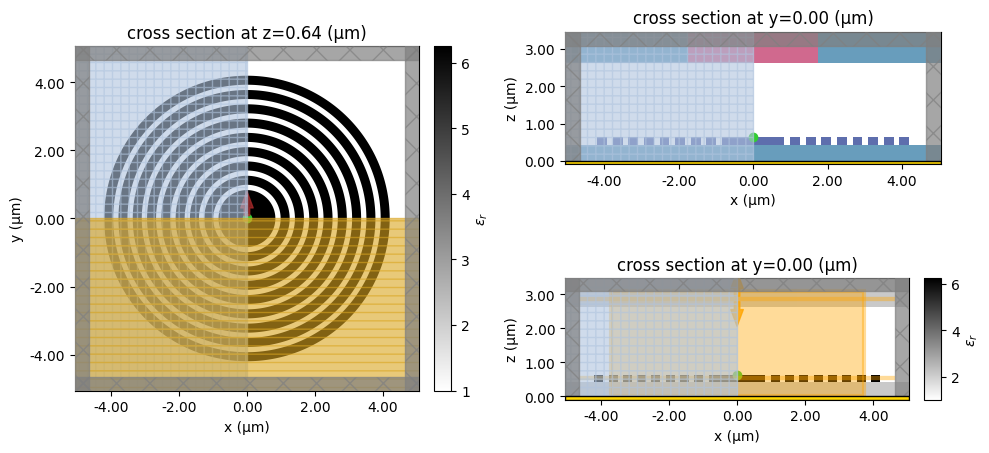

In [5]:
init_design = get_simulation()

fig = plt.figure(tight_layout=True, figsize=(10, 5))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])
init_design.plot_eps(z=t_sio2 + t_tio2, ax=ax1, monitor_alpha=0)
init_design.plot(y=0, ax=ax2, monitor_alpha=0)
init_design.plot_eps(y=0, ax=ax3)
plt.show()

## Output Fiber Mode

Before running the optimization, we will make sure the correct optical fiber mode has been considered.

In [7]:
mode_spec = td.ModeSpec(num_modes=1, target_neff=n_core)
mode_solver = ModeSolver(
    simulation=init_design,
    plane=td.Box(
        center=(0, 0, 0.5 * pml_spacing + t_sio2 + t_tio2 + d_cf),
        size=(td.inf, td.inf, 0),
    ),
    mode_spec=mode_spec,
    freqs=[freq],
)
mode_fiber = run_mode_solver(mode_solver)

13:10:23 BST WARNING: Mode monitor 'mode_fiber' has a large number (2.21e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             Mode solver created with                                           
             task_id='fdve-af9009c2-1efa-49cb-8e53-8c19826da55a',               
             solver_id='mo-754dae8e-39fd-436c-a7ce-cf324bade44b'.

Output()

Output()

13:10:26 BST Mode solver status: queued

13:10:40 BST Mode solver status: running

13:10:54 BST Mode solver status: success

Output()

We can see the y-oriented fundamental optical fiber mode, as desired.

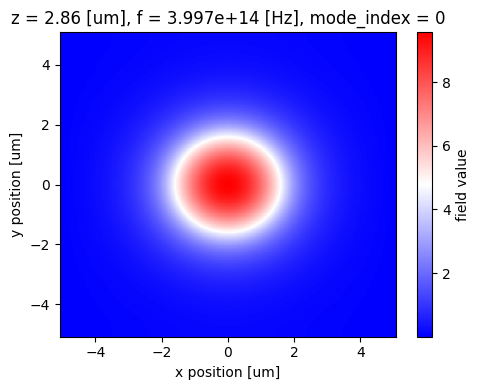

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
mode_fiber.Ey.real.sel(mode_index=0, f=freq).plot(x="x", y="y", cmap="bwr", ax=ax)
plt.show()

## Particle Swarm Optimization


The figure-of-merit used in the optimization is the coupling efficiency of generated photons into the fundamental optical mode of the collection fiber. We need to normalize the modal power by the dipole power to obtain the correct value, as below.

In [9]:
# Figure of Merit (FOM) calculation.
def get_coupling_eff(sim_data: td.SimulationData) -> float:
    """Return the power at the mode index of interest."""
    mode_amps = sim_data["mode_fiber"].amps.sel(direction="+", mode_index=0)
    mode_power = np.squeeze(np.abs(mode_amps) ** 2)
    dip_power = sim_data["flux_dip"].flux
    return mode_power / dip_power

Now we can define the pre and post functions that the `DesignSpace` needs to carry out the PSO. The `fn_pre` will receive keyword arguments suggested from the optimizer and returns a `Simulation` object. This `Simulation` will automatically be combined into a `Batch` and run in parallel on the Tidy3D cloud, for fast computation of each PSO iteration.

The `fn_post` function receives the `SimulationData` from the computation and calculates the maximising FOM defined above. All optimizers in the `Design` plugin are maximising functions so no minus sign is needed to reverse this FOM. The output float value is fed to the PSO to evaluate the current solution and improve the next suggestion.

In [10]:
def fn_pre(r: float, p: float, w: float, h: float, t_sio2: float, dcf: float) -> td.Simulation:
    """Build a Simulation object from parameters suggested by the PSO."""
    sim = get_simulation(r, p, w, h, t_sio2, dcf)
    return sim

def fn_post(sim_data: td.SimulationData) -> float:
    """Analyze SimulationData from a bullseye cavity simulation and return coupling efficiency."""
    ce = np.max(get_coupling_eff(sim_data))
    return float(ce)

Each parameter is then defined with the `name` matching the argument in `fn_pre`. The PSO will work within the bounds specified in the `span` to suggest solutions. To make this notebook reproducible we also define the initial position and set the seed - though this isn't necessary for every PSO run.

In the `Method` we define the hyperparameters used to setup the PSO (the inertia weight, the cognitive coefficient, and the social coefficient) which typically require some experimentation to find the optimum values. We have done some iteration to choose these values, but they could likely be refined further.

The `Method` and `Parameters` are then input to the `DesignSpace` which controls the optimization and returns the results.

In [11]:
# Setup parameters for DesignSpace
r_param = tdd.ParameterFloat(name="r", span=(0.5 * r_cav, 1.5 * r_cav))
p_param = tdd.ParameterFloat(name="p", span=(0.5 * p_bragg, 1.5 * p_bragg))
w_param = tdd.ParameterFloat(name="w", span=(0.5 * w_bragg, 1.5 * w_bragg))
h_param = tdd.ParameterFloat(name="h", span=(0.0, 1.0))
t_sio2_param = tdd.ParameterFloat(name="t_sio2", span=(0.5 * t_sio2, 1.5 * t_sio2))
dcf_param = tdd.ParameterFloat(name="dcf", span=(0.5 * d_cf, 1.5 * d_cf))
parameters = (r_param, p_param, w_param, h_param, t_sio2_param, dcf_param)

# Initial parameters
np.random.seed(3)
init_par = np.random.uniform(0.5, 1.0, (n_particle, len(parameters)))
init_par[:, 0] = init_par[:, 0] * r_cav
init_par[:, 1] = init_par[:, 1] * p_bragg
init_par[:, 2] = init_par[:, 2] * w_bragg
init_par[:, 3] = init_par[:, 3] - 0.5
init_par[:, 4] = init_par[:, 4] * t_sio2
init_par[:, 5] = init_par[:, 5] * d_cf

particle_swarm=tdd.MethodParticleSwarm(
    n_particles=n_particle, 
    n_iter=iterations,
    cognitive_coeff=0.5,
    social_coeff=0.3,
    weight=0.9,
    init_pos=init_par,
)

design_space = tdd.DesignSpace(method=particle_swarm, parameters=parameters, task_name="PSO_Notebook", path_dir="./data")

Now, we are ready to run the optimization!

In [12]:
td.config.logging_level = "ERROR"

# Run the optimization
results = design_space.run(fn_pre, fn_post, verbose=True)
df = results.to_dataframe()

2024-08-18 13:11:14,546 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/15

13:11:14 BST Running 5 Simulations

pyswarms.single.global_best:   7%|▋         |1/15, best_cost=-0.114

13:14:17 BST Running 5 Simulations

pyswarms.single.global_best:  13%|█▎        |2/15, best_cost=-0.154

13:16:41 BST Running 5 Simulations

pyswarms.single.global_best:  20%|██        |3/15, best_cost=-0.227

13:18:50 BST Running 5 Simulations

pyswarms.single.global_best:  27%|██▋       |4/15, best_cost=-0.227

13:22:00 BST Running 5 Simulations

pyswarms.single.global_best:  33%|███▎      |5/15, best_cost=-0.227

13:24:05 BST Running 5 Simulations

pyswarms.single.global_best:  40%|████      |6/15, best_cost=-0.227

13:26:00 BST Running 5 Simulations

pyswarms.single.global_best:  47%|████▋     |7/15, best_cost=-0.227

13:28:01 BST Running 5 Simulations

pyswarms.single.global_best:  53%|█████▎    |8/15, best_cost=-0.227

13:29:59 BST Running 5 Simulations

pyswarms.single.global_best:  60%|██████    |9/15, best_cost=-0.332

13:32:14 BST Running 5 Simulations

pyswarms.single.global_best:  67%|██████▋   |10/15, best_cost=-0.332

13:34:08 BST Running 5 Simulations

pyswarms.single.global_best:  73%|███████▎  |11/15, best_cost=-0.332

13:36:28 BST Running 5 Simulations

pyswarms.single.global_best:  80%|████████  |12/15, best_cost=-0.332

13:38:26 BST Running 5 Simulations

pyswarms.single.global_best:  87%|████████▋ |13/15, best_cost=-0.332

13:40:41 BST Running 5 Simulations

pyswarms.single.global_best:  93%|█████████▎|14/15, best_cost=-0.332

13:42:50 BST Running 5 Simulations

pyswarms.single.global_best: 100%|██████████|15/15, best_cost=-0.332
2024-08-18 13:45:14,788 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.3316617392831616, best pos: [0.74632414 0.3812908  0.12455691 0.26602631 0.64924378 1.0869887 ]


13:45:14 BST Best Result: -0.3316617392831616                                   
             Best Parameters: r: 0.7463241440689826 p: 0.3812907960183133 w:    
             0.1245569125769858 h: 0.26602630907617625 t_sio2:                  
             0.6492437787750074 dcf: 1.0869886995014149                         
             

Ultimately, we can obtain the optimized cavity parameters and see how the optimization has evolved into the final value. When optimizing a device for practical applications, one can consider adding more particles, increasing the number of iterations, or trying different metaparameters to improve results.

Best parameters:
r_cav = 0.746 um
p_bragg = 0.381 um
w_bragg = 0.125 um
h = 0.266
t_sio2 = 0.649 um
d_cf = 1.087 um


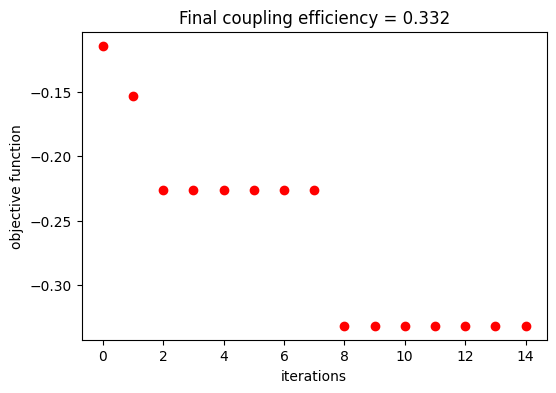

In [13]:
# The optimizer object is stored in the results from the DesignSpace
best_par = results.optimizer.swarm.best_pos
cost_history = results.optimizer.cost_history

print(f"Best parameters:")
print(f"r_cav = {best_par[0]:.3f} um")
print(f"p_bragg = {best_par[1]:.3f} um")
print(f"w_bragg = {best_par[2]:.3f} um")
print(f"h = {best_par[3]:.3f}")
print(f"t_sio2 = {best_par[4]:.3f} um")
print(f"d_cf = {best_par[5]:.3f} um")

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(cost_history, "ro")
ax.set_xlabel("iterations")
ax.set_ylabel("objective function")
ax.set_title(f"Final coupling efficiency = {-min(cost_history):.3f}")
plt.show()

## Final Bullseye Cavity

Now, we can simulate the optimized bullseye cavity and take a look at the coupling efficiency along the whole bandwidth.

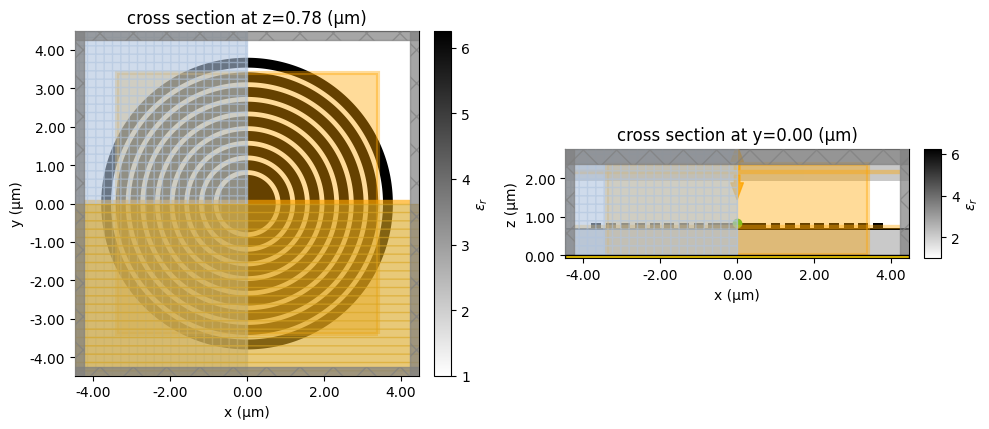

In [14]:
final_design = get_simulation(
    r=best_par[0],
    p=best_par[1],
    w=best_par[2],
    h=best_par[3],
    tsio2=best_par[4],
    dcf=best_par[5],
)

# Field monitor to visualize the fields at the peak coupling efficiency.
wl_mon = 0.725 # Wavelength for field monitor.
field_monitor_xz_f = td.FieldMonitor(
    center=(0, 0.05, final_design.center[2]/2),
    size=(final_design.size[0], 0, final_design.size[2]),
    freqs=[td.C_0/wl_mon],
    name="field_xz_f",
)

mon_f = final_design.monitors + (field_monitor_xz_f,)
final_design = final_design.copy(update=dict(monitors=mon_f))

fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 5))
final_design.plot_eps(z=best_par[4] + t_tio2 / 1.5, ax=ax1)
final_design.plot_eps(y=0, ax=ax2)
plt.show()

In [15]:
sim_data_final = web.run(final_design, task_name="final bullseye")

14:48:56 BST Created task 'final bullseye' with task_id                         
             'fdve-933b9ffc-408f-4513-b6dd-5307a50786fc' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=238298;https://tidy3d.simulation.cloud/workbench?taskId=fdve-933b9ffc-408f-4513-b6dd-5307a50786fc\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=131698;https://tidy3d.simulation.cloud/workbench?taskId=fdve-933b9ffc-408f-4513-b6dd-5307a50786fc\taskId]8;;\]8;id=238298;https://tidy3d.simulation.cloud/workbench?taskId=fdve-933b9ffc-408f-4513-b6dd-5307a50786fc\=]8;;\]8;id=831;https://tidy3d.simulation.cloud/workbench?taskId=fdve-933b9ffc-408f-4513-b6dd-5307a50786fc\fdve]8;;\]8;id=238298;https://tidy3d.simulation.cloud/workbench?taskId=fdve-933b9ffc-408f-4513-b6dd-5307a50786fc\-933b9ffc-408]8;;\
             ]8;id=238298;https://tidy3d.simulation.cloud/workbench?taskId=fdve-933b9ffc-408f-4513-b6dd-5307a50786fc\f-4513-b6dd-5307a50786fc']8;;\.

Output()

14:48:59 BST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

14:49:17 BST status = preprocess

14:49:18 BST Maximum FlexCredit cost: 0.329. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

14:49:59 BST early shutoff detected at 20%, exiting.

             status = postprocess

Output()

14:50:36 BST status = success

14:50:37 BST View simulation result at                                          
             ]8;id=755854;https://tidy3d.simulation.cloud/workbench?taskId=fdve-933b9ffc-408f-4513-b6dd-5307a50786fc\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=303418;https://tidy3d.simulation.cloud/workbench?taskId=fdve-933b9ffc-408f-4513-b6dd-5307a50786fc\taskId]8;;\]8;id=755854;https://tidy3d.simulation.cloud/workbench?taskId=fdve-933b9ffc-408f-4513-b6dd-5307a50786fc\=]8;;\]8;id=593705;https://tidy3d.simulation.cloud/workbench?taskId=fdve-933b9ffc-408f-4513-b6dd-5307a50786fc\fdve]8;;\]8;id=755854;https://tidy3d.simulation.cloud/workbench?taskId=fdve-933b9ffc-408f-4513-b6dd-5307a50786fc\-933b9ffc-408]8;;\
             ]8;id=755854;https://tidy3d.simulation.cloud/workbench?taskId=fdve-933b9ffc-408f-4513-b6dd-5307a50786fc\f-4513-b6dd-5307a50786fc']8;;\.

Output()

14:50:39 BST loading simulation from simulation_data.hdf5


The peak coupling efficiency is about 33% at 0.76 $\mu m$.

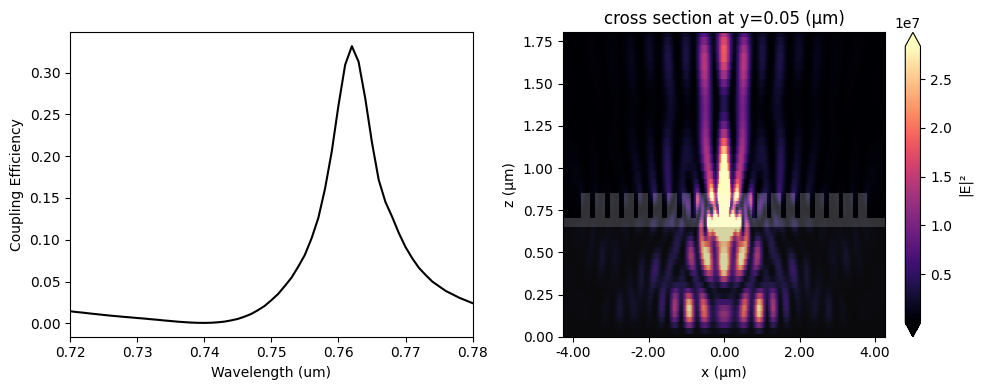

In [16]:
coup_eff = get_coupling_eff(sim_data_final)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
ax1.plot(wl_range, coup_eff, "-k")
ax1.set_xlabel("Wavelength (um)")
ax1.set_ylabel("Coupling Efficiency")
ax1.set_xlim(wl - bw / 2, wl + bw / 2)
sim_data_final.plot_field("field_xz_f", "E", "abs^2", ax=ax2)
ax2.set_aspect("auto")
plt.show()

## Purcell Factor Calculation

Purcell factor enhancement is usually desired when designing a quantum emitter light extractor device, as it can lead to higher photon generation rates, $\beta$-factors, and photon indistinguishability. Next, we calculate the bullseye nanocavity Purcell factor ($F_{p} = P_{cav}/P_{bulk}$) defined as the ratio between the dipole power emitted in final device and in the bulk semiconductor.

We can calculate $P_{bulk}$ analytically as

$P_{bulk_a} = \frac{\omega^{2}}{12\pi}\frac{\mu_{0}n}{c}$

where $n$ is the refractive index of the quantum emitter host material.

In [14]:
p_bulk_a = ((2 * np.pi * freqs) ** 2 / (12 * np.pi)) * (td.MU_0 * n_tio2 / td.C_0)


When symmetries are present in the simulation, dipole image charges are included for each symmetry plane due to field continuity reasons. In this case, we need to adjust $P_{bulk_a}$ as below:

In [15]:
p_bulk_a = p_bulk_a * 2 ** (2 * np.sum(np.abs(final_design.symmetry)))

Another way of obtaining $P_{bulk}$ is through a normalization run considering the quantum emitter embedded in a homogeneous medium, as follows. Note that the same symmetry condition of the cavity simulation should be used. 

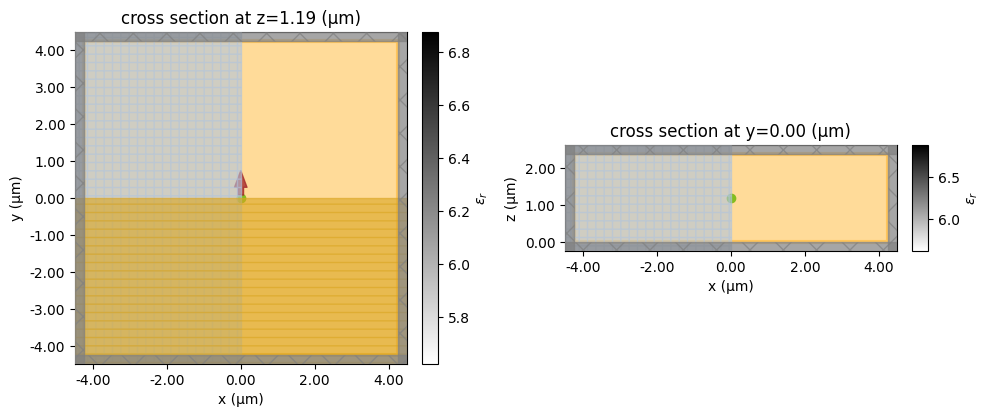

In [16]:
# Point dipole source located at the center of TiO2 thin film.
dp_source_bulk = td.PointDipole(
    center=(0, 0, final_design.size[2] / 2),
    source_time=td.GaussianPulse(freq0=freq, fwidth=freqw),
    polarization="Ey",
)

# Flux monitor to get the total dipole power.
flux_dip_bulk = td.FluxMonitor(
    center=(0, 0, final_design.size[2] / 2),
    size=final_design.size,
    freqs=freqs,
    name="flux_dip_bulk",
)

bulk_device = final_design.copy(
    update={
        "structures": [],
        "sources": [dp_source_bulk],
        "monitors": [flux_dip_bulk],
        "medium": mat_tio2,
        "symmetry": final_design.symmetry,
        "boundary_spec": td.BoundarySpec.all_sides(boundary=td.PML()),
    }
)

fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 5))
bulk_device.plot_eps(z=(final_design.size[2]) / 2, ax=ax1)
bulk_device.plot_eps(y=0, ax=ax2)
plt.show()

In [17]:
sim_data_bulk = web.run(bulk_device, task_name="bulk sim")

10:57:29 BST Created task 'bulk sim' with task_id                               
             'fdve-04d7dec3-b1d9-43f8-be75-982e2aaf0247' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=857212;https://tidy3d.simulation.cloud/workbench?taskId=fdve-04d7dec3-b1d9-43f8-be75-982e2aaf0247\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=476941;https://tidy3d.simulation.cloud/workbench?taskId=fdve-04d7dec3-b1d9-43f8-be75-982e2aaf0247\taskId]8;;\]8;id=857212;https://tidy3d.simulation.cloud/workbench?taskId=fdve-04d7dec3-b1d9-43f8-be75-982e2aaf0247\=]8;;\]8;id=489692;https://tidy3d.simulation.cloud/workbench?taskId=fdve-04d7dec3-b1d9-43f8-be75-982e2aaf0247\fdve]8;;\]8;id=857212;https://tidy3d.simulation.cloud/workbench?taskId=fdve-04d7dec3-b1d9-43f8-be75-982e2aaf0247\-04d7dec3-b1d]8;;\
             ]8;id=857212;https://tidy3d.simulation.cloud/workbench?taskId=fdve-04d7dec3-b1d9-43f8-be75-982e2aaf0247\9-43f8-be75-982e2aaf0247']8;;\.

Output()

10:57:31 BST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

10:57:44 BST status = preprocess

10:57:46 BST Maximum FlexCredit cost: 0.362. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

10:57:57 BST early shutoff detected at 4%, exiting.

             status = success

             View simulation result at                                          
             ]8;id=148796;https://tidy3d.simulation.cloud/workbench?taskId=fdve-04d7dec3-b1d9-43f8-be75-982e2aaf0247\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=917009;https://tidy3d.simulation.cloud/workbench?taskId=fdve-04d7dec3-b1d9-43f8-be75-982e2aaf0247\taskId]8;;\]8;id=148796;https://tidy3d.simulation.cloud/workbench?taskId=fdve-04d7dec3-b1d9-43f8-be75-982e2aaf0247\=]8;;\]8;id=15299;https://tidy3d.simulation.cloud/workbench?taskId=fdve-04d7dec3-b1d9-43f8-be75-982e2aaf0247\fdve]8;;\]8;id=148796;https://tidy3d.simulation.cloud/workbench?taskId=fdve-04d7dec3-b1d9-43f8-be75-982e2aaf0247\-04d7dec3-b1d]8;;\
             ]8;id=148796;https://tidy3d.simulation.cloud/workbench?taskId=fdve-04d7dec3-b1d9-43f8-be75-982e2aaf0247\9-43f8-be75-982e2aaf0247']8;;\.

Output()

10:57:58 BST loading simulation from simulation_data.hdf5

A maximum Purcell value of about 4.75 is achieved at 0.76 $\mu m$, even though this figure-of-merit was not pursued along the optimization. Higher Purcell values can be obtained in cases where the quantum emitter can be embedded within the cavity material.

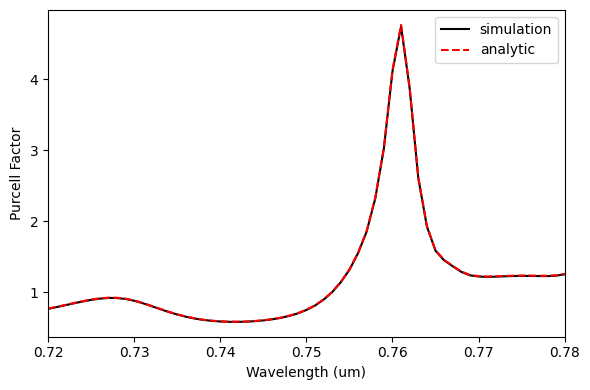

In [20]:
p_cav = sim_data_final["flux_dip"].flux
p_bulk_s = sim_data_bulk["flux_dip_bulk"].flux

purcell_s = p_cav / p_bulk_s
purcell_a = p_cav / p_bulk_a

f, ax1 = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)
ax1.plot(wl_range, purcell_s, "-k", label="simulation")
ax1.plot(wl_range, purcell_a, "--r", label="analytic")
ax1.set_xlabel("Wavelength (um)")
ax1.set_ylabel("Purcell Factor")
ax1.set_xlim(wl - bw / 2, wl + bw / 2)
plt.legend()
plt.show()